In [136]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [137]:
#Importing dataset and defining path variables
path = './data/'
smallfile = 'clean_ipo_stock_2010_2018.csv'
largefile = 'master_data.csv'

df = pd.read_csv(path + smallfile, index_col='ipoDate')
df

,Price,employees,CEO_age,intra_day_up,intra_week_up,intra_month_up,Name,Symbol,sector,IPO_weekday,firstday_volume,inweek_volume,inmonth_volume,SP500_lastweek_return
ipoDate,,,,,,,,,,,,,,
2010-01-26,6.3,128.0,57.460211,1,1,0,ANDATEE CHINA MARINE FUEL SERVICES CORP,AMCF,Energy,1,9.555630e+05,5.932224e+06,6.363594e+06,-0.007087
2010-01-22,20.0,3.0,60.000000,1,1,1,CHESAPEAKE LODGING TRUST,CHSP,Real Estate,4,3.492458e+06,6.008493e+05,1.913988e+06,-0.005608
2010-02-11,13.0,1486.0,50.000000,1,1,1,GENERAC HOLDINGS INC.,GNRC,Industrials,3,1.689209e+07,2.179334e+06,4.954609e+06,-0.003156
2010-02-11,15.0,568.0,62.000000,0,1,0,"QUINSTREET, INC",QNST,Technology,3,5.372077e+06,3.362175e+06,7.004538e+06,-0.003156
2010-02-10,20.0,6.0,61.000000,1,1,1,TERRENO REALTY CORP,TRNO,Real Estate,2,4.515261e+06,7.616977e+05,1.939840e+06,-0.002686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-12,13.0,2559.0,48.000000,0,1,0,TENCENT MUSIC ENTERTAINMENT GROUP,TME,Technology,2,6.028340e+07,1.319195e+08,1.973692e+08,-0.005634
2018-12-07,11.0,25.0,64.000000,0,0,0,"SYNTHORX, INC.",THOR,Healthcare,4,1.193371e+07,9.200986e+06,2.655808e+07,-0.002472
2018-12-07,4.0,11.0,51.000000,0,0,0,DIAMEDICA THERAPEUTICS INC.,DMAC,Healthcare,4,1.124000e+06,1.950800e+06,2.791700e+06,-0.002472


In [138]:
#Dropping Symbol and Name columns
df.drop(columns=['Symbol', 'Name'], inplace=True, axis = 1)

#One hot encoding sector and weekday cols
categorical_cols = ['sector', 'IPO_weekday'] 
df = pd.get_dummies(df, columns = categorical_cols)

In [139]:
#Normalizing numerical variables for ML modeling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

normalized_data_small = scaler.fit_transform(df)
df_norm = pd.DataFrame(normalized_data_small, columns=df.columns)

In [140]:
#Logistic Regression Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics

X = df_norm.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up', 'firstday_volume', 'inweek_volume', 'inmonth_volume'])
y_d = np.array(df_norm.intra_day_up)
y_w = np.array(df_norm.intra_week_up)
y_m = np.array(df.intra_month_up)

#Looking at class imbalances
print('Class distribution: \n',df_norm[['intra_day_up','intra_week_up', 'intra_month_up']].mean())

#Dealing with class imbalances by oversampling minority class (underperforming IPOs)
sm = SMOTE(random_state=27)
X_d_bal, y_d_bal = sm.fit_resample(X, y_d)
X_w_bal, y_w_bal = sm.fit_resample(X, y_w)
X_m_bal, y_m_bal = sm.fit_resample(X, y_m)

#Printing mean of y values (should be 0.5, since data should now be balanced)
print('Class distribution after SMOTE: {:.2f}'.format(y_d_bal.mean()))

#Model accuracy does not improve substantially with SMOTE, but recall and balanced acc does.

# setting up stratified testing and training sets
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d_bal, y_d_bal, test_size=0.2, random_state=0, stratify = y_d_bal)
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w_bal, y_w_bal, test_size=0.2, random_state=0, stratify = y_w_bal)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m_bal, y_m_bal, test_size=0.2, random_state=0, stratify = y_m_bal)

Class distribution: 
 intra_day_up      0.418682
intra_week_up     0.443703
intra_month_up    0.453711
dtype: float64
Class distribution after SMOTE: 0.50


In [141]:
#Fitting Logistic Regression Models
logreg_d = LogisticRegression()
logreg_w = LogisticRegression()
logreg_m = LogisticRegression()

logreg_d.fit(X_d_train, y_d_train)
logreg_w.fit(X_w_train, y_w_train)
logreg_m.fit(X_m_train, y_m_train)


LogisticRegression()

In [142]:
log_pred_d = logreg_d.predict(X_d_test)
log_pred_w = logreg_w.predict(X_w_test)
log_pred_m = logreg_m.predict(X_m_test)
print('Accuracy of logistic regression classifier on daily up test set: {:.2f}'.format(logreg_d.score(X_d_test, y_d_test)))
print('Accuracy of logistic regression classifier on weekly up test set: {:.2f}'.format(logreg_w.score(X_w_test, y_w_test)))
print('Accuracy of logistic regression classifier on monthly up test set: {:.2f}'.format(logreg_m.score(X_m_test, y_m_test)))

Accuracy of logistic regression classifier on daily up test set: 0.69
Accuracy of logistic regression classifier on weekly up test set: 0.69
Accuracy of logistic regression classifier on monthly up test set: 0.65


In [143]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(classification_report(y_d_test, log_pred_d))
confusion_matrix = confusion_matrix(y_d_test, log_pred_d)

#TN #FP
#FN #TP
print(confusion_matrix)



              precision    recall  f1-score   support

         0.0       0.65      0.81      0.72       140
         1.0       0.75      0.57      0.64       139

    accuracy                           0.69       279
   macro avg       0.70      0.69      0.68       279
weighted avg       0.70      0.69      0.68       279

[[113  27]
 [ 60  79]]


In [144]:
from sklearn.model_selection import RandomizedSearchCV
#Creating grid search for Random Forest Hyperparameter Tuning
#Taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [145]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base models to tune for each predicted label
rf_d = RandomForestClassifier()
rf_w = RandomForestClassifier()
rf_m = RandomForestClassifier()

# Random search of parameters, using 10 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random_d = RandomizedSearchCV(estimator = rf_d, param_distributions = random_grid, n_iter = 50, cv = 10, random_state=42, n_jobs = -1)
rf_random_w = RandomizedSearchCV(estimator = rf_w, param_distributions = random_grid, n_iter = 50, cv = 10, random_state=42, n_jobs = -1)
rf_random_m = RandomizedSearchCV(estimator = rf_m, param_distributions = random_grid, n_iter = 50, cv = 10, random_state=42, n_jobs = -1)

# Fit all random search models (Takes ca. 12 min to run)
rf_random_d.fit(X_d_train, y_d_train)

print('First randomized search completed.')

rf_random_w.fit(X_w_train, y_w_train)

print('Second randomized search completed.')

rf_random_m.fit(X_m_train, y_m_train)

First randomized search completed.
Second randomized search completed.


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 255, 411, 566,
                                                         722, 877, 1033, 1188,
                                                         1344, 1500]},
                   random_state=42)

In [146]:
#Evaluating accuracy of rf models
best_random_d = rf_random_d.best_estimator_
best_random_w = rf_random_w.best_estimator_
best_random_m = rf_random_m.best_estimator_

#Creating random model predictions
rf_predictions_d = best_random_d.predict(X_d_test)
rf_predictions_w = best_random_d.predict(X_w_test)
rf_predictions_m = best_random_d.predict(X_m_test)

#Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy of random forest classifier on daily up test set: {:.2f}'.format(balanced_accuracy_score(y_d_test, rf_predictions_d)))
print('Balanced accuracy of random forest classifier on weekly up test set: {:.2f}'.format(balanced_accuracy_score(y_w_test, rf_predictions_w)))
print('Balanced accuracy of random forest classifier on monthly up test set: {:.2f}'.format(balanced_accuracy_score(y_m_test, rf_predictions_m)))

Balanced accuracy of random forest classifier on daily up test set: 0.69
Balanced accuracy of random forest classifier on weekly up test set: 0.81
Balanced accuracy of random forest classifier on monthly up test set: 0.75


In [147]:
from xgboost import XGBClassifier

#Creating XGB models for each predicted label
xgb_d = XGBClassifier(objective="binary:logistic")
xgb_w = XGBClassifier(objective="binary:logistic")
xgb_m = XGBClassifier(objective="binary:logistic")

#Defining search grid for randomized search
param_grid = {
    "max_depth": [int(x) for x in np.linspace(10, 200, num = 10)],
    "learning_rate": [0.1, 0.01, 0.05, 0.2, 0.25, 0.3],
    "gamma": [0, 0.1, 0.25, 0.5, 1],
    "reg_lambda": [0, 1, 2, 5, 10],
    "scale_pos_weight": [1, 2, 3, 4, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

#Fitting randomized search to XGB models
xgb_random_d = RandomizedSearchCV(estimator = xgb_d, param_distributions = param_grid, n_iter = 50, cv = 10, random_state=42, n_jobs = -1)
xgb_random_w = RandomizedSearchCV(estimator = xgb_w, param_distributions = param_grid, n_iter = 50, cv = 10, random_state=42, n_jobs = -1)
xgb_random_m = RandomizedSearchCV(estimator = xgb_m, param_distributions = param_grid, n_iter = 50, cv = 10, random_state=42, n_jobs = -1)

#Fitting search to training data (Takes around 15 min to run)
xgb_random_d.fit(X_d_train, y_d_train)

print('First randomized search completed.')

xgb_random_w.fit(X_w_train, y_w_train)

print('Second randomized search completed.')

xgb_random_m.fit(X_m_train, y_m_train)

First randomized search completed.
Second randomized search completed.


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5],
                                        'gamma': [0, 0.1, 0.25, 0.5, 1],
                                        'learning_rate': [0.1, 0.01, 0.05, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [10, 31, 52, 73, 94, 115,
                                                      136, 157, 178, 200],
                                        'reg_lambda': [0, 1, 2, 5, 10],
                                        'scale_pos_weight': [1, 2, 3, 4, 5],
                                        'subsample': [0.8]},
                   random_state=42)

In [148]:
#Evaluating accuracy of xgb models
best_random_d = xgb_random_d.best_estimator_
best_random_w = xgb_random_w.best_estimator_
best_random_m = xgb_random_m.best_estimator_

#Creating random model predictions
xgb_predictions_d = best_random_d.predict(X_d_test)
xgb_predictions_w = best_random_d.predict(X_w_test)
xgb_predictions_m = best_random_d.predict(X_m_test)

#Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy of xgboost classifier on daily up test set: {:.2f}'.format(balanced_accuracy_score(y_d_test, xgb_predictions_d)))
print('Balanced accuracy of xgboost classifier on weekly up test set: {:.2f}'.format(balanced_accuracy_score(y_w_test, xgb_predictions_w)))
print('Balanced accuracy of xgboost classifier on monthly up test set: {:.2f}'.format(balanced_accuracy_score(y_m_test, xgb_predictions_m)))

Balanced accuracy of xgboost classifier on daily up test set: 0.72
Balanced accuracy of xgboost classifier on weekly up test set: 0.82
Balanced accuracy of xgboost classifier on monthly up test set: 0.79


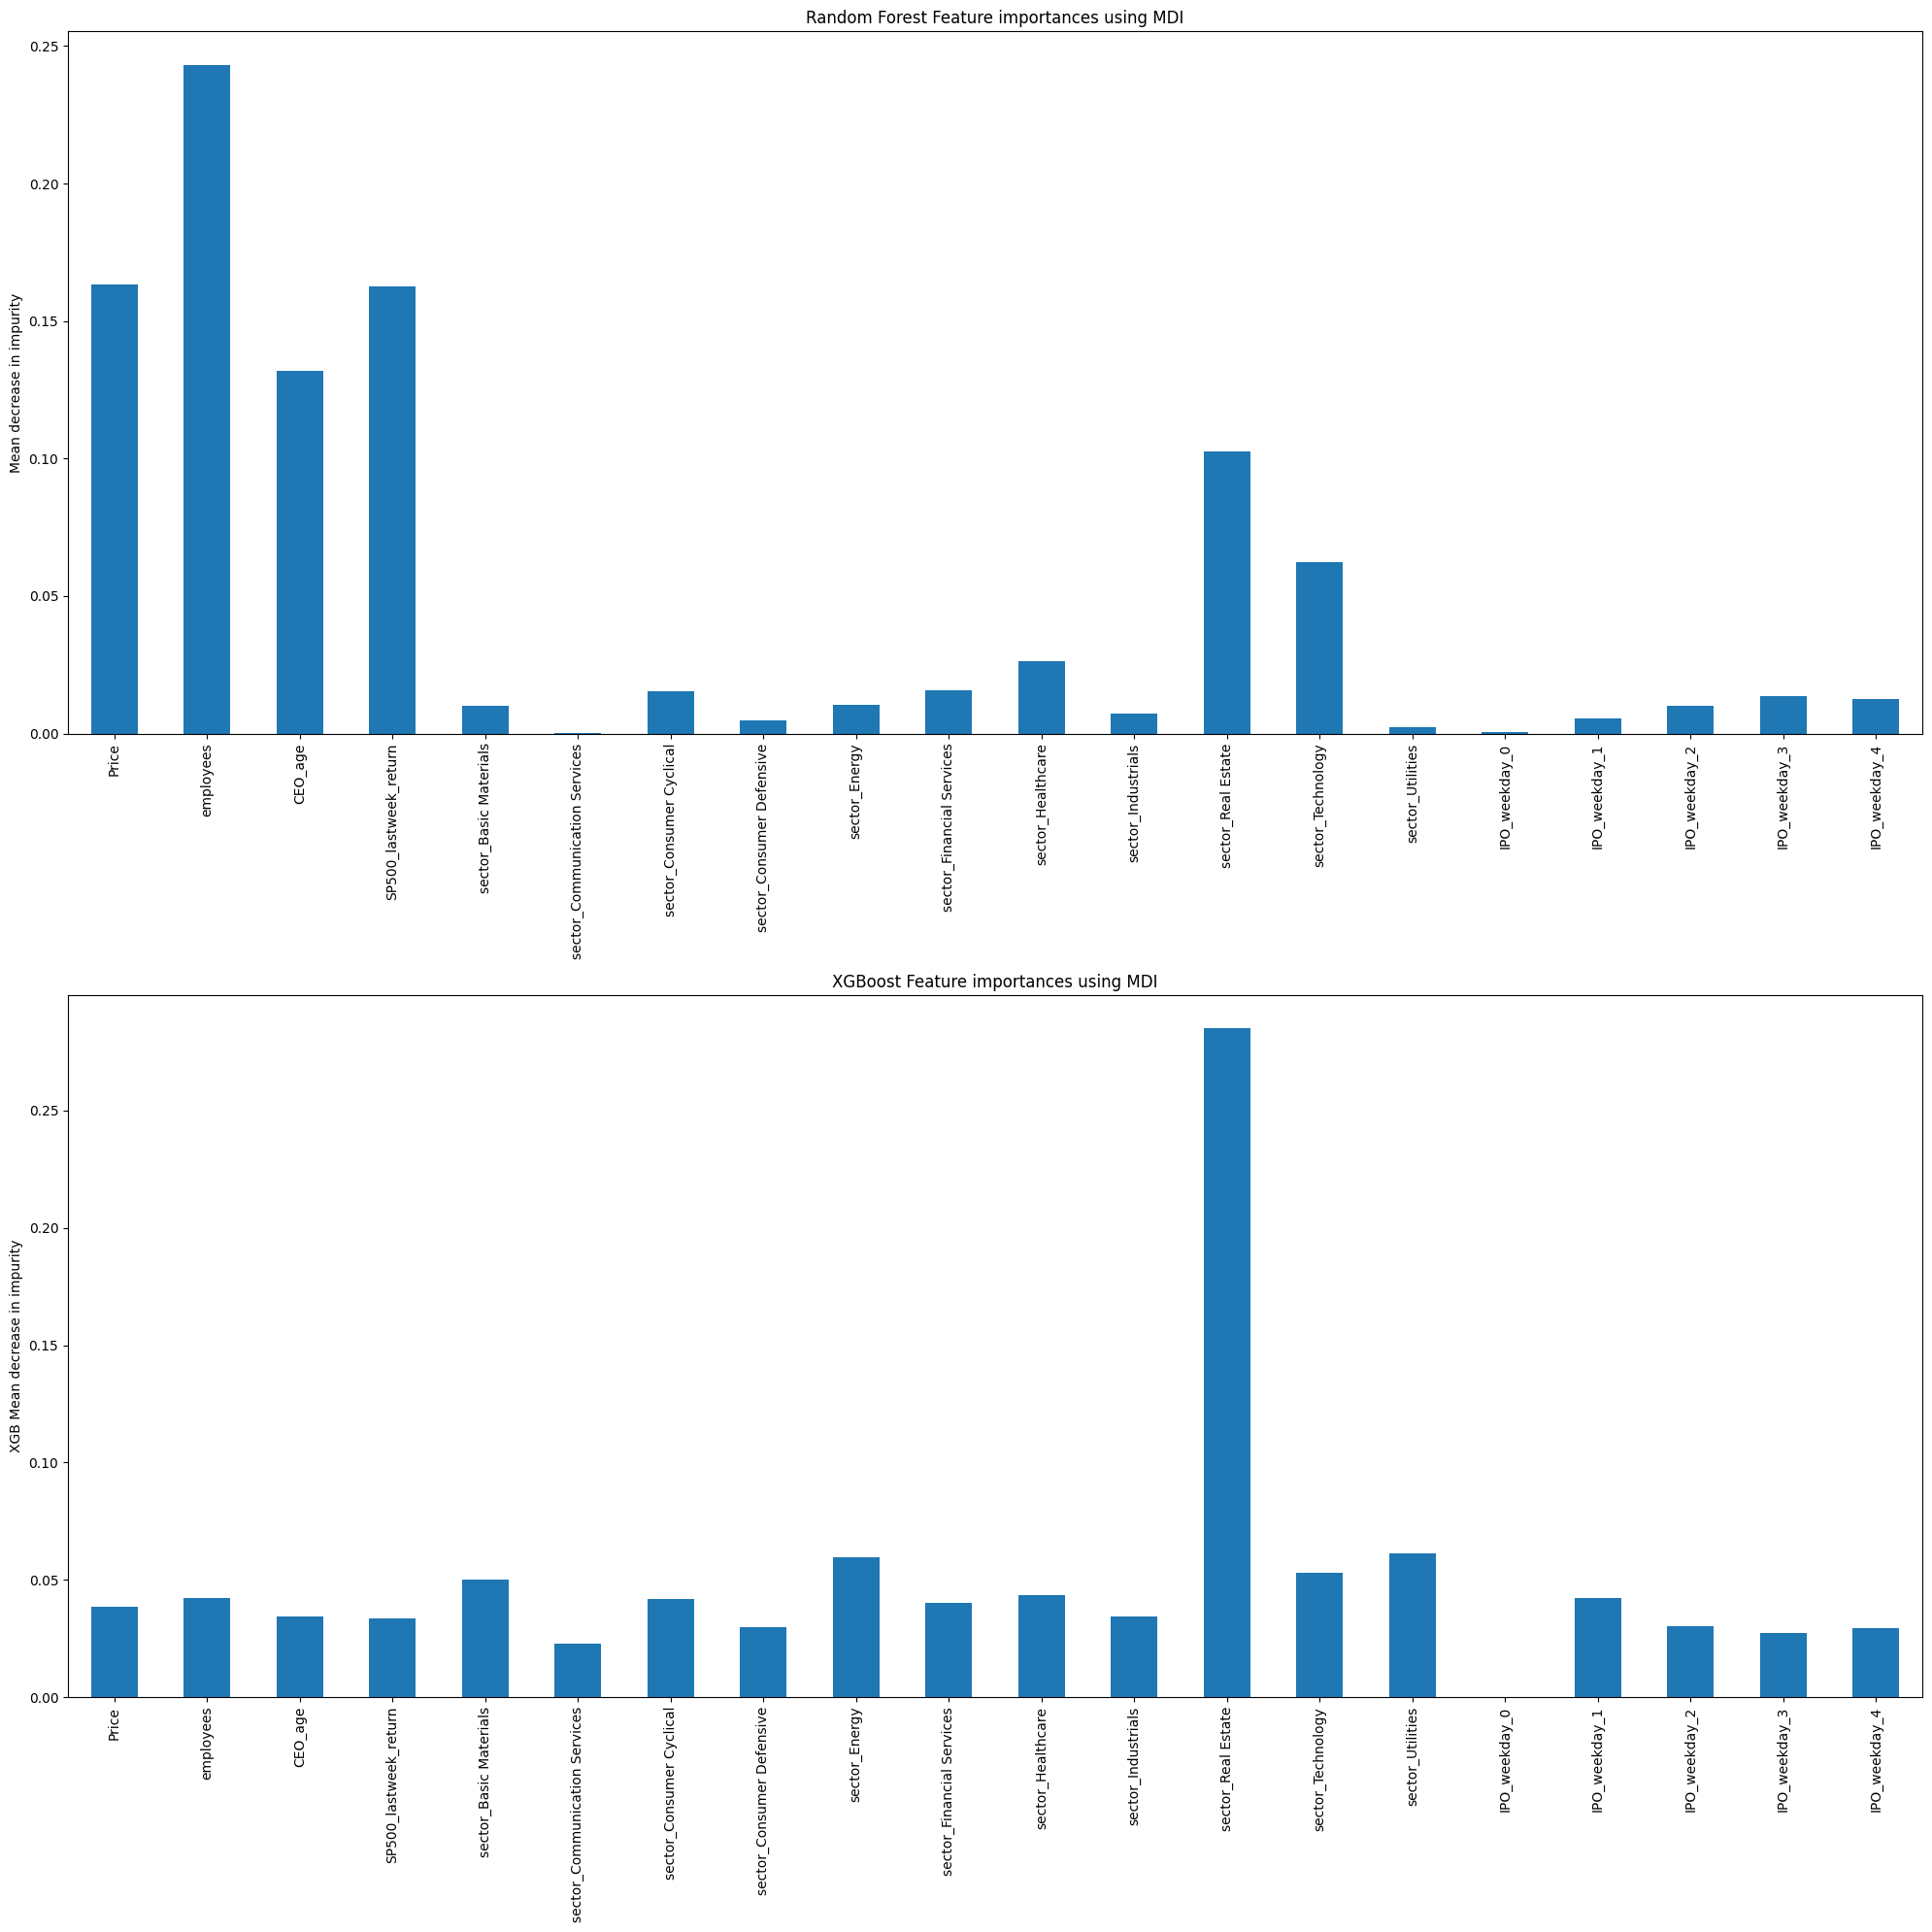

In [149]:
#Looking at feature importances across models

#Feature importance for rf models
feature_names = [col for col in X.columns]
rf_d_importance = pd.Series(rf_random_d.best_estimator_.feature_importances_, index = feature_names)
rf_w_importance = pd.Series(rf_random_w.best_estimator_.feature_importances_, index = feature_names)
rf_m_importance = pd.Series(rf_random_m.best_estimator_.feature_importances_, index = feature_names)

#Feature importance for xgb models
xgb_d_importance = pd.Series(xgb_random_d.best_estimator_.feature_importances_, index = feature_names)
xgb_w_importance = pd.Series(xgb_random_w.best_estimator_.feature_importances_, index = feature_names)
xgb_m_importance = pd.Series(xgb_random_m.best_estimator_.feature_importances_, index = feature_names)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,20))
rf_d_importance.plot.bar(ax=ax1)
xgb_d_importance.plot.bar(ax = ax2)
ax1.set_title("Random Forest Feature importances using MDI")
ax1.set_ylabel("Mean decrease in impurity")
ax2.set_title("XGBoost Feature importances using MDI")
ax2.set_ylabel("XGB Mean decrease in impurity")
fig.tight_layout()


In [150]:
xgb_d_importance.sort_values(ascending=False)

sector_Real Estate               0.285059
sector_Utilities                 0.061337
sector_Energy                    0.059816
sector_Technology                0.053092
sector_Basic Materials           0.050258
sector_Healthcare                0.043511
employees                        0.042358
IPO_weekday_1                    0.042222
sector_Consumer Cyclical         0.041815
sector_Financial Services        0.040020
Price                            0.038671
CEO_age                          0.034343
sector_Industrials               0.034249
SP500_lastweek_return            0.033401
IPO_weekday_2                    0.030357
sector_Consumer Defensive        0.029605
IPO_weekday_4                    0.029485
IPO_weekday_3                    0.027520
sector_Communication Services    0.022882
IPO_weekday_0                    0.000000
dtype: float32

In [151]:
rf_d_importance.sort_values(ascending=False)

employees                        0.243175
Price                            0.163331
SP500_lastweek_return            0.162574
CEO_age                          0.131762
sector_Real Estate               0.102453
sector_Technology                0.062281
sector_Healthcare                0.026166
sector_Financial Services        0.015715
sector_Consumer Cyclical         0.015311
IPO_weekday_3                    0.013745
IPO_weekday_4                    0.012474
sector_Energy                    0.010566
sector_Basic Materials           0.010147
IPO_weekday_2                    0.010126
sector_Industrials               0.007139
IPO_weekday_1                    0.005378
sector_Consumer Defensive        0.004671
sector_Utilities                 0.002171
IPO_weekday_0                    0.000633
sector_Communication Services    0.000181
dtype: float64

In [152]:
#Looking at most important features in logistic regression model
log_d_importance = pd.Series(abs(logreg_d.coef_[0]), index = X.columns)
log_w_importance = pd.Series(abs(logreg_w.coef_[0]), index = X.columns)
log_m_importance = pd.Series(abs(logreg_m.coef_[0]), index = X.columns)

In [153]:
#Result aggregation

#RF results
rf_results = pd.DataFrame({'pred_label':[], 'accuracy': [], 'balanced_accuracy': [], 'top_5_features': []})
rf_results['model'] = ['RFModel']*3
rf_results.accuracy = [accuracy_score(y_d_test, rf_predictions_d), accuracy_score(y_w_test, rf_predictions_w), accuracy_score(y_m_test, rf_predictions_m)]
rf_results.balanced_accuracy = [balanced_accuracy_score(y_d_test, rf_predictions_d), balanced_accuracy_score(y_w_test, rf_predictions_w), balanced_accuracy_score(y_m_test, rf_predictions_m)]
rf_results.top_5_features = [rf_d_importance.nlargest(5).index.tolist(), rf_w_importance.nlargest(5).index.tolist(), rf_m_importance.nlargest(5).index.tolist()]
rf_results.pred_label = ['intra day underperformance', 'in-week underperformance', 'in-month underperformance']


#XGB results
xgb_results = pd.DataFrame({'pred_label':[], 'accuracy': [], 'balanced_accuracy': [], 'top_5_features': []})
xgb_results['model'] = ['XGBoost']*3
xgb_results.accuracy = [accuracy_score(y_d_test, xgb_predictions_d), accuracy_score(y_w_test, xgb_predictions_w), accuracy_score(y_m_test, xgb_predictions_m)]
xgb_results.balanced_accuracy = [balanced_accuracy_score(y_d_test, xgb_predictions_d), balanced_accuracy_score(y_w_test, xgb_predictions_w), balanced_accuracy_score(y_m_test, xgb_predictions_m)]
xgb_results.top_5_features = [xgb_d_importance.nlargest(5).index.tolist(), xgb_w_importance.nlargest(5).index.tolist(), xgb_m_importance.nlargest(5).index.tolist()]
xgb_results.pred_label = ['intra day underperformance', 'in-week underperformance', 'in-month underperformance']


#Logreg results
log_results = pd.DataFrame({'pred_label':[], 'accuracy': [], 'balanced_accuracy': [], 'top_5_features': []})
log_results['model'] = ['Logreg']*3
log_results.accuracy = [accuracy_score(y_d_test, log_pred_d), accuracy_score(y_w_test, log_pred_w), accuracy_score(y_m_test, log_pred_m)]
log_results.balanced_accuracy = [balanced_accuracy_score(y_d_test, log_pred_d), balanced_accuracy_score(y_w_test, log_pred_w), balanced_accuracy_score(y_m_test, log_pred_m)]
log_results.top_5_features = [log_d_importance.nlargest(5).index.tolist(), log_w_importance.nlargest(5).index.tolist(), log_m_importance.nlargest(5).index.tolist()]
log_results.pred_label = ['intra day underperformance', 'in-week underperformance', 'in-month underperformance']


pd.concat([rf_results, xgb_results, log_results], axis = 0)

,pred_label,accuracy,balanced_accuracy,top_5_features,model
0,intra day underperformance,0.691756,0.691521,"[employees, Price, SP500_lastweek_return, CEO_...",RFModel
1,in-week underperformance,0.808989,0.808692,"[employees, SP500_lastweek_return, Price, CEO_...",RFModel
2,in-month underperformance,0.751908,0.751908,"[employees, SP500_lastweek_return, Price, CEO_...",RFModel
0,intra day underperformance,0.724014,0.723767,"[sector_Real Estate, sector_Utilities, sector_...",XGBoost
1,in-week underperformance,0.823970,0.823701,"[sector_Real Estate, sector_Energy, sector_Tec...",XGBoost
2,in-month underperformance,0.793893,0.793893,"[sector_Real Estate, sector_Utilities, sector_...",XGBoost
0,intra day underperformance,0.688172,0.687744,"[sector_Real Estate, sector_Technology, SP500_...",Logreg
1,in-week underperformance,0.689139,0.688587,"[sector_Real Estate, SP500_lastweek_return, Pr...",Logreg
2,in-month underperformance,0.652672,0.652672,"[sector_Real Estate, sector_Technology, sector...",Logreg
